# SCC0251 - Digital Image Processing
### Assigment 2: Image Enhancement and Filtering

Daniel Penna Chaves Bertazzo - USP number: 10349561
<br>
First semester of 2020

In this assigment, three methods of image filtering/enhancement must be implemented: 
- Bilateral filter
- Unsharp mask using the Laplacian filter
- Vignette filter
<br><br>
The goal of this notebook is to show examples of all methods and their results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Auxiliary functions
These functions will be used throughout the assignment, many times in more than just one method.

In [2]:
# Gaussian kernel
def G(x, sigma):
    term1 = 1.0 / (2.0 * np.pi * (np.square(sigma)))
    term2 = np.exp( -np.square(x) / (2.0 * (np.square(sigma))) )
    
    return term1 * term2

In [3]:
# Euclidean distance between 2 points
def E(x, y):
    return float(np.sqrt(np.square(x) + np.square(y)))

In [4]:
# Normalizes the image to the interval (0 - 255)
def normalize(r):
    return ( ((r - np.amin(r)) * 255) / (np.amax(r) - np.amin(r)) )

In [5]:
def rse(r, m):
    '''
    Computes the Root Squared Error (RSE) between the original image and the
    image generated after the transformation.
    Input:
        r: original image
        m: modified image
    Return:
       root squared error value 
    '''
    return np.sqrt(np.sum(np.square(m.astype(np.float64) - r.astype(np.float64))))

# 1) Bilateral filter

## 1.1) Functions

In [6]:
# Generates spatial component
def generate_sc(n, sigma):
    spatial_comp = np.zeros((n, n))
    
    # Shift that will be used to center the filter's indices at the center of the matrix
    shift = int((n-1) / 2)
    
    # Runs through the filter's matrix
    for x in range(n):
        for y in range(n):
            spatial_comp[x, y] = G(E(x-shift, y-shift), sigma)
            
    return spatial_comp

In [7]:
# Performs the convolution using the bilateral filter
def conv2d_bf(r, spatial_comp, sigma_s, sigma_r):

    n = spatial_comp.shape[0] # Gets filter size
    shift = int((n-1) / 2)    # Computes the shift value for the indices
    
    # Zero-pads the image, allowing it to be entirely processed by the filter
    r_padded = np.pad(r, pad_width=shift, mode='constant', constant_values=0).astype(np.uint8)
    N, M = r_padded.shape  # Gets image dimensions after padding
    
    # Matrix that will hold the image after convolution is complete
    f = np.zeros(r.shape)
    
    # Filter initialization
    w = np.zeros((n, n))
        
    # Runs through the image
    for x in range(shift, N-shift):
        for y in range(shift, M-shift):
            
            # Centers the filter on the (x, y) pixel (getting submatrix around it)
            r_sub = r_padded[ x-shift : x+shift+1 , y-shift : y+shift+1 ]
            
            I_f = 0.0  # New value of centered pixel (f[x, y])
            W_p = 0.0
        
            # Runs through the filter's window size
            for i in range(n):
                for j in range(n):
                
                    '''
                    Step 1
                    gr_i = G(I_i - I(x,y), sigma_r)
                    
                    where
                    
                    I_i     = intensity of neighbor pixel (== r_sub[i, j])
                    I(x,y)  = intensity of center pixel (== r_padded[x, y])
                    sigma_r = sigma_r
                    '''
                    gr_i = G(float(r_sub[i, j]) - float(r_padded[x, y]), sigma_r)
                    
                
                    '''
                    Step 2
                    w_i = gr_i * gs_i
                    
                    where
                    
                    w_i  = total value of the filter on this neighbor (== w[i, j])
                    gr_i = range component (== gr_i)
                    gs_i = spatial component (== spatial_comp[i, j])
                    '''
                    w[i, j] = gr_i * spatial_comp[i, j]

                    
                    '''
                    Step 3
                    W_p = W_p + w_i
                    
                    where
                    
                    W_p = normalization factor (== W_p)
                    w_i = value of filter on this neighbor (== w[i, j])
                    '''
                    W_p += w[i, j]
                    
                    
                    '''
                    Step 4
                    I_f = I_f + w_i * I_i
                    
                    where
                    
                    I_f = new value of the centered pixel (== I_f -> will be f[x, y])
                    w_i = filter value on this neighbor (== w[i, j])
                    I_i = intensity of this neighbor pixel (== r_sub[i, j])
                    '''
                    I_f += w[i, j] * float(r_sub[i, j])
                    
                
                    '''
                    Final step
                    I_f = I_f / W_p
                    
                    where
                    
                    I_f = new image pixel (== I_f == f[x, y])
                    W_p = normalization factor (== W_p)
                    '''
                    f[x-shift, y-shift] = I_f / W_p
                

    return f.astype(np.uint8)

## 1.2) Execution and results

File name = images/camera.png
Save? [1] or [0] = 0
Filter size = 3
Sigma_s = 150.0
Sigma_r = 100.0


Root squared error = 3429.3615


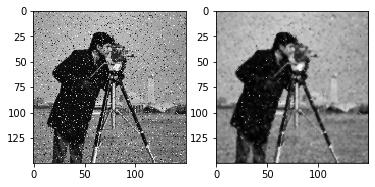

In [8]:
# ..:: Reading input ::..

print("File name = ", end='')
filename = str(input())
r = imageio.imread(filename)

print("Save? [1] or [0] = ", end='')
save = int(input()) 

# Reads parameters
print("Filter size = ", end='')
filter_size = int(input())
print("Sigma_s = ", end='')
sigma_s = float(input())
print("Sigma_r = ", end='')
sigma_r = float(input())

# Computes operation
spatial_component = generate_sc(filter_size, sigma_s)
f = conv2d_bf(r, spatial_component, sigma_s, sigma_r)

# Saves image if needed
if save == 1:
    imageio.imwrite("resulting_image", f)


# ..:: Printing results ::..
plt.subplot(121)
plt.imshow(r, cmap='gray')
plt.subplot(122)
plt.imshow(f, cmap='gray')
print("\n\nRoot squared error = %.4f" % rse(r, f))

# 2) Unsharp mask using the Laplacian Filter

## 2.1) Functions

In [9]:
# Computes the convolution using one of two laplacian filter kernels
def conv2d_lf(r, kernel):
    
    # Generates kernel of type 1
    if kernel == 1:
        w = np.matrix([[ 0, -1,  0],
                       [-1,  4, -1],
                       [ 0, -1,  0]])
    
    # Generates kernel of type 2
    elif kernel == 2:
        w = np.matrix([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])    
    
    else:
        print("Error: invalid kernel")
        return None
    
    
    # Gets filter size
    n = w.shape[0]
    
    # Gets size of convolution intervals
    shift = int((n-1) / 2)
    
    # Flips the filter (not necessary in these cases, but flipping anyway)
    wf = np.flip(np.flip(w, 0), 1)
    
    # Zero-pads the image, allowing it to be entirely processed by the filter
    r_padded = np.pad(r, pad_width=shift, mode='constant', constant_values=0).astype(np.uint8)
    N, M = r_padded.shape  # Gets image dimensions after padding
        
    # Matrix that will hold the filtered image
    I_f = np.zeros(r.shape)
    
    # Runs through the image matrix
    for x in range(shift, N-shift):
        for y in range(shift, M-shift):
            
            # Centers the filter on the (x, y) pixel (getting submatrix around it)
            sub_r = r_padded[x-shift : x+shift+1 , y-shift : y+shift+1]
                    
            # Computes the cross-correlation between the subset and the flipped filter,
            # resulting in a convolution operation
            I_f[x-shift, y-shift] = np.sum(np.multiply(sub_r, wf))
            
    
    return I_f

## 2.1) Execution and results

File name = images/arara.png
Save? [1] or [0] = 0
c = 0.75
Kernel [1] or [2] = 2


Root squared error = 6893.6062


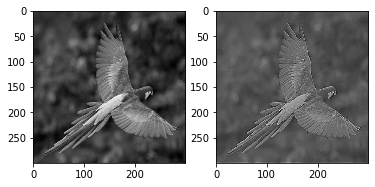

In [10]:
# ..:: Reading input ::..

print("File name = ", end='')
filename = str(input())
r = imageio.imread(filename)

print("Save? [1] or [0] = ", end='')
save = int(input()) 

# Reads parameters
print("c = ", end='')
c = float(input())
print("Kernel [1] or [2] = ", end='')
kernel = int(input())

# Computes operation
I_f = conv2d_lf(r, kernel)
I_f = normalize(I_f)
f   = np.multiply(c, I_f) + r
f   = normalize(f).astype(np.uint8)

# Saves image if needed
if save == 1:
    imageio.imwrite("resulting_image.png", f)
    

# ..:: Printing results ::..
plt.subplot(121)
plt.imshow(r, cmap='gray')
plt.subplot(122)
plt.imshow(f, cmap='gray')
print("\n\nRoot squared error = %.4f" % rse(r, f))

# 3) Vignette filter

## 3.1) Functions

In [11]:
# Returns one-dimensional gaussian kernel respective to the rows and another respective to the cols
def gaussian_kernel_1d(shape, sigma_row, sigma_col):
    
    # Sizes of both kernels (column and row respectively)
    N, M = shape
    
    if N%2 == 0:
        shift_row = int(N/2) - 1
    else:
        shift_row = int((N-1) / 2)
    
    if M%2 == 0:
        shift_col = int(M/2) - 1
    else:
        shift_col = int((M-1) / 2)
    
    # Initializes kernels
    w_row = np.zeros(N)
    w_col = np.zeros(M)
    
    # Computes row kernel
    for i in range(N):
        w_row[i] = G(i-shift_row, sigma_row)
    
    # Computes column kernel
    for i in range(M):
        w_col[i] = G(i-shift_col, sigma_col)
    
    
    # Returns as matrix so that the subsequent multiplication between w_row.T and w_col
    # results in a matrix with the correct dimensions (same as the original image)
    return np.asmatrix(w_row), np.asmatrix(w_col)

## 3.2) Execution and results

File name = images/flower.png
Save? [1] or [0] = 0
Sigma_row = 50.0
Sigma_col = 50.0


Root squared error = 16972.4239


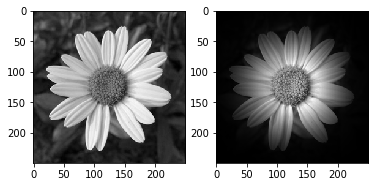

In [12]:
# ..:: Reading input ::..

print("File name = ", end='')
filename = str(input())
r = imageio.imread(filename)

print("Save? [1] or [0] = ", end='')
save = int(input()) 

# Reads parameters
print("Sigma_row = ", end='')
sigma_row = float(input())
print("Sigma_col = ", end='')
sigma_col = float(input())

# Computes operation
w_row, w_col = gaussian_kernel_1d(r.shape, sigma_row, sigma_col)
filter_array = np.matmul(w_row.T, w_col)
f = np.multiply(filter_array, r)
f = normalize(f)
    
# Saves image if needed
if save == 1:
    imageio.imwrite("resulting_image.png", f)
    

# ..:: Printing results ::..
plt.subplot(121)
plt.imshow(r, cmap='gray')
plt.subplot(122)
plt.imshow(f, cmap='gray')
print("\n\nRoot squared error = %.4f" % rse(r, f))